## Importing dependencies and modules

In [1]:
import pandas as pd
import gensim
import multiprocessing
import numpy as np

## Importing dataset 

In [2]:
# importing data
df = pd.read_csv('C:/Users/Rachele/PycharmProjects/topicmodeling/tweets_dataframe.csv', encoding="utf-8")
list_of_tweets = df['full_text'].tolist()

print(list_of_tweets[90:100])

['@claytonbathiany #GreysAnatomy', "Et ce soir c'était #GreysAnatomy 👌😍", 'Ahh right in the heart.\nOuch.\n-2x9-\n{#greysanatomy} https://t.co/OFrC6xj9Ih', 'Grey’s anatomy shock: Patrick Dempsey licenziato per una relazione clandestina? http://t.co/xOgEfvgU2G\n\n#greysanatomy #patrickdempsey', 'Yo @shondarhimes we out shopping for our #ScandalFinale party, and we need to know what kind of popcorn Liv eats😩😂  cc: @kerrywashington', "I don't think there can be a grey's anatomy without Derek. Season 12 is going to be so bland without the MerDer love story.", 'Check my bio. #recent #adidas #balenciaga #likeforlikes #wcw #harrypotter #allday #aot #greysanatomy #workselfie #t… http://t.co/VEr9Be6ns5', 'gente, eu achando q a musica tinha sido feita toda pra falar q o mcdreamy tava morto e tava tudo ok. É musica sobre ABC e o cara fala isso', 'animadona, afinal, a porra da serie continua mesmo; Eu jurava q a musica só falava isso KKKKKKKKKKK mas ele fala q em ga o mcdreamy morreu', "@TheCosby 

## Preprocessing

### Removing non-English tweets from data

In [5]:
import fasttext as ft

# import pre-trained model
ft_model = ft.load_model("C:/Users/Rachele/Downloads/lid.176.ftz")

english_tweets = []

for tweet in list_of_tweets:
    tweet = tweet.replace('\n', " ") # so that fasttext does not throw an error
    prediction = ft_model.predict(tweet)
    label = prediction[0]
    if label == ('__label__en',):
        english_tweets.append(tweet)
    else:
        continue

In [6]:
for tweet in english_tweets:       
    output = open(('C:/Users/Rachele/Documents/englishtweets/'+tweet.strip())+'.txt','w')
    output.close()

OSError: [Errno 22] Invalid argument: 'C:/Users/Rachele/Documents/englishtweets/I snapped this of Patrick, Eric and Jesse sitting around and being awesome waiting for the table read... http://t.co/P0ZDmEm.txt'

### Text cleaning

In [14]:
import re
import string
import emoji
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

# function to remove urls, mentions, hashtags and punctuation, lowercasing, tokenizing and stopwording
def text_cleaning(text):
    global clean_tweets
    clean_tweets = []
    for t in english_tweets:
        clean_tweet = re.sub(r'(?:\@|https?\://)\S+', '', t).lower()  # regex to remove urls and mentions, lowercasing
        clean_tweet = re.sub('#[A-Za-z0-9_]+', '', clean_tweet)  # remove hashtags
        clean_tweet = re.sub(r'([A-Za-z])\1{2,}', r'\1', clean_tweet) # remove characters which are repeated more than twice
        clean_tweet = emoji.replace_emoji(clean_tweet) # remove emojis
        clean_tweet = clean_tweet.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
        clean_tweet = re.sub('([0-9]+)', '', clean_tweet) # remove numbers
        clean_tweets.append(clean_tweet) # create list of cleaned tweets
    tokenizer = TweetTokenizer()
    tokens = []
    for i in clean_tweets:
        token = tokenizer.tokenize(i)
        token = filter(lambda t: len(t) > 3, token) # exclude tokens shorter than 3 characters
        tokens.append(token) # create list of tokens
    stop_words = set(stopwords.words("english"))
    filtered_tweet = []
    tweets = []
    for tweet in tokens:
        filtered_tweet = [w for w in tweet if not w in stop_words] # remove stopwords from list
        tweets.append(filtered_tweet)
    tweets = [x for x in tweets if x != []]
    return tweets

tweets = text_cleaning(english_tweets)

print(tweets[230:250])

[['dont', 'care', 'mcdreamy'], ['meredith', 'christina', 'moment'], ['shondas', 'team', 'putting', 'false', 'dirt', 'patrick', 'always', 'classy'], ['netflix', 'getting', 'binge'], ['mcdreamy', 'isnt', 'saved', 'autocorrect', 'thats', 'upsetting'], ['okay', 'shonda', 'freakin', 'damn', 'show'], ['always', 'though', 'shonda', 'obviously', 'doesnt', 'always', 'stay', 'course'], ['biggest', 'crush', 'patrick', 'dempsey'], ['deacon', 'dies', 'tonight', 'going', 'able', 'handle', 'shows', 'cant', 'mcdreamy', 'deacon'], ['always', 'bout', 'mcdreamy'], ['owen', 'mcdreamy', 'mcsteamy', 'three', 'together', 'damn'], ['still', 'mcdreamys', 'death', 'weeks', 'still', 'randomly', 'beautiful', 'dammit'], ['jolex', 'makes', 'want', 'powdered', 'sugar', 'donut'], ['like', 'mins', 'last', 'weeks', 'episode', 'thought', 'tell', 'ideas', 'season'], ['watching', 'greys', 'cant', 'stop', 'thinking', 'dumb', 'killing', 'mcdreamy', 'feel', 'show', 'anymore'], ['humiliating'], ['youre', 'facebook'], ['talkin

In [20]:
import csv

with open('C:/Users/Rachele/Documents/preprocessedtweets.csv', 'w', encoding="utf-8") as f:
    write = csv.writer(f)
    write.writerows(tweets)

## Top2Vec

In [91]:
clean_tweets = []
for t in english_tweets:
    clean_tweet = re.sub(r'(?:\@|https?\://)\S+', '', t).lower()  # regex to remove urls and mentions, lowercasing
    clean_tweet = re.sub('#[A-Za-z0-9_]+', '', clean_tweet)  # regex to remove hashtags
    clean_tweet = re.sub(r'([A-Za-z])\1{2,}', r'\1', clean_tweet) # removes characters which are repeated more than twice
    clean_tweet = emoji.replace_emoji(clean_tweet) # removes emojis
    clean_tweet = clean_tweet.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    clean_tweets.append(clean_tweet) # create list of cleaned tweets

In [44]:
from top2vec import Top2Vec

# doc2vec is used by default to generate the joint word and document embeddings
model = Top2Vec(clean_tweets, workers=4)

2022-08-08 10:46:17,508 - top2vec - INFO - Pre-processing documents for training
2022-08-08 10:46:18,534 - top2vec - INFO - Creating joint document/word embedding
2022-08-08 10:47:32,784 - top2vec - INFO - Creating lower dimension embedding of documents
2022-08-08 10:47:50,902 - top2vec - INFO - Finding dense areas of documents
2022-08-08 10:47:52,837 - top2vec - INFO - Finding topics


In [45]:
# save model
model.save("C:/Users/Rachele/Documents/NLP Models/GAt2v-2.t2v")

In [93]:
# load model
model = Top2Vec.load("C:/Users/Rachele/Documents/NLP Models/GAt2v-2.t2v")

In [94]:
# get number of topics generated
model.get_num_topics()

2

In [48]:
topic_words, word_scores, topic_nums = model.get_topics(2)

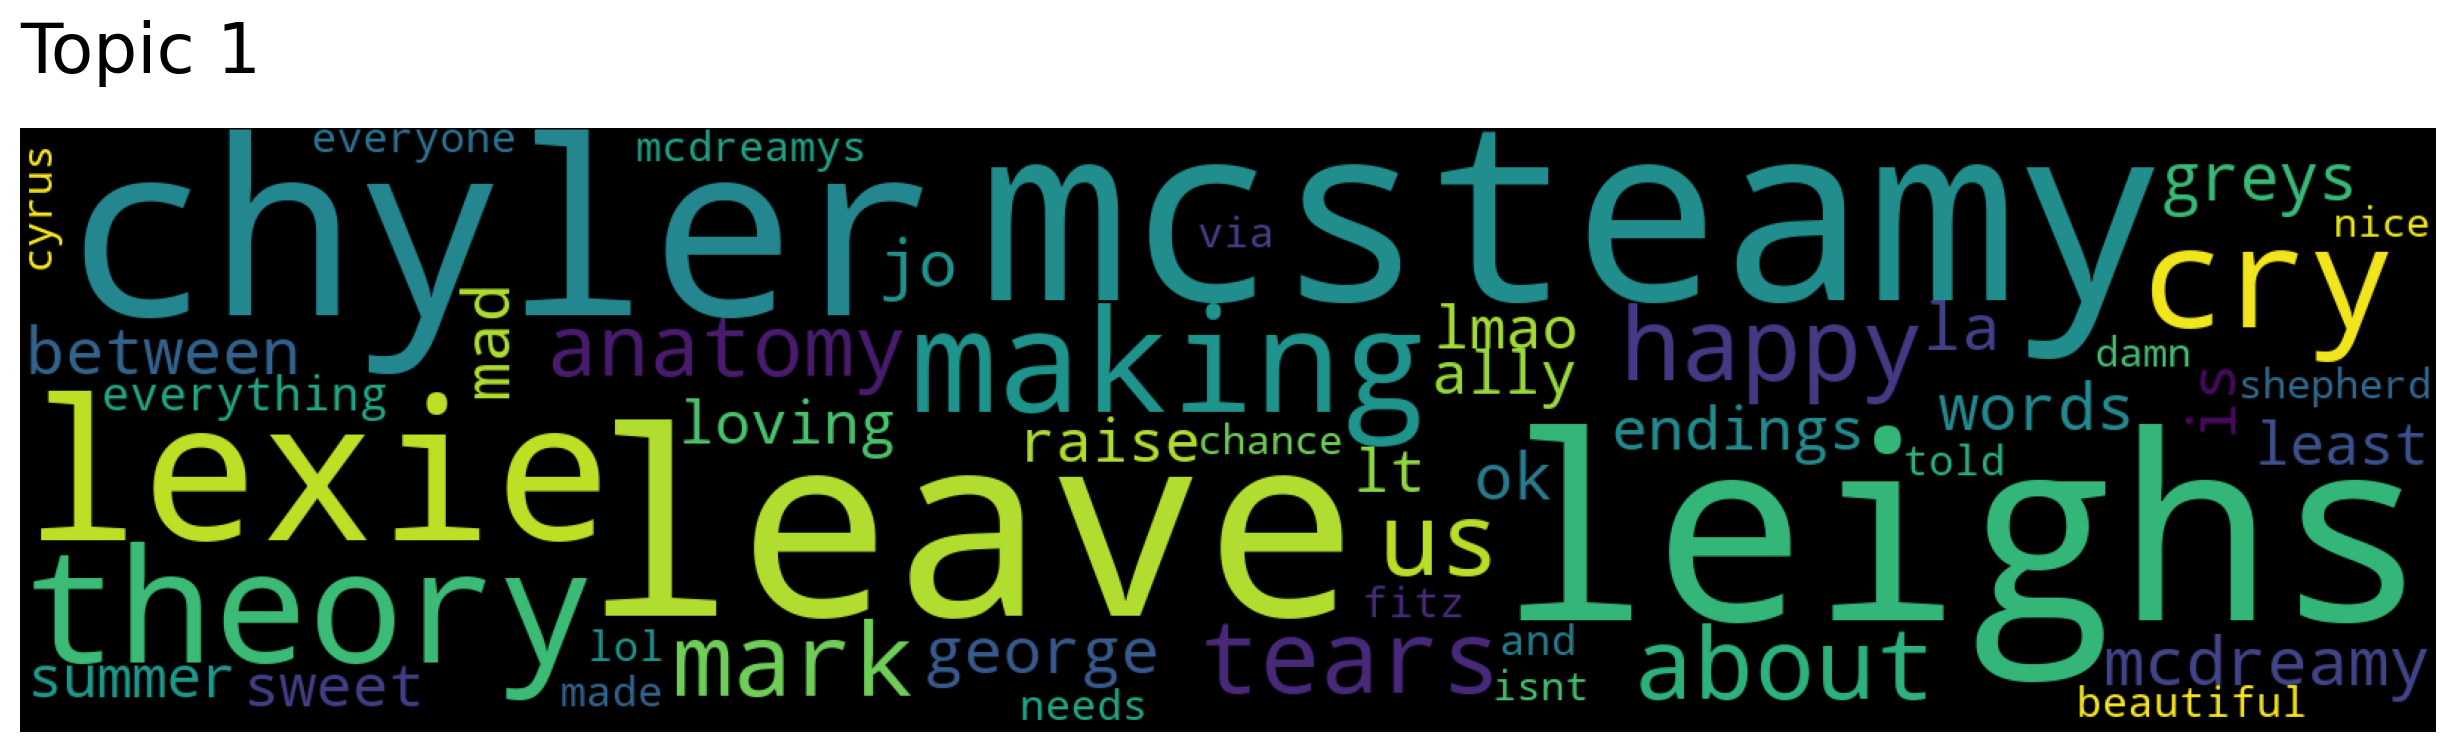

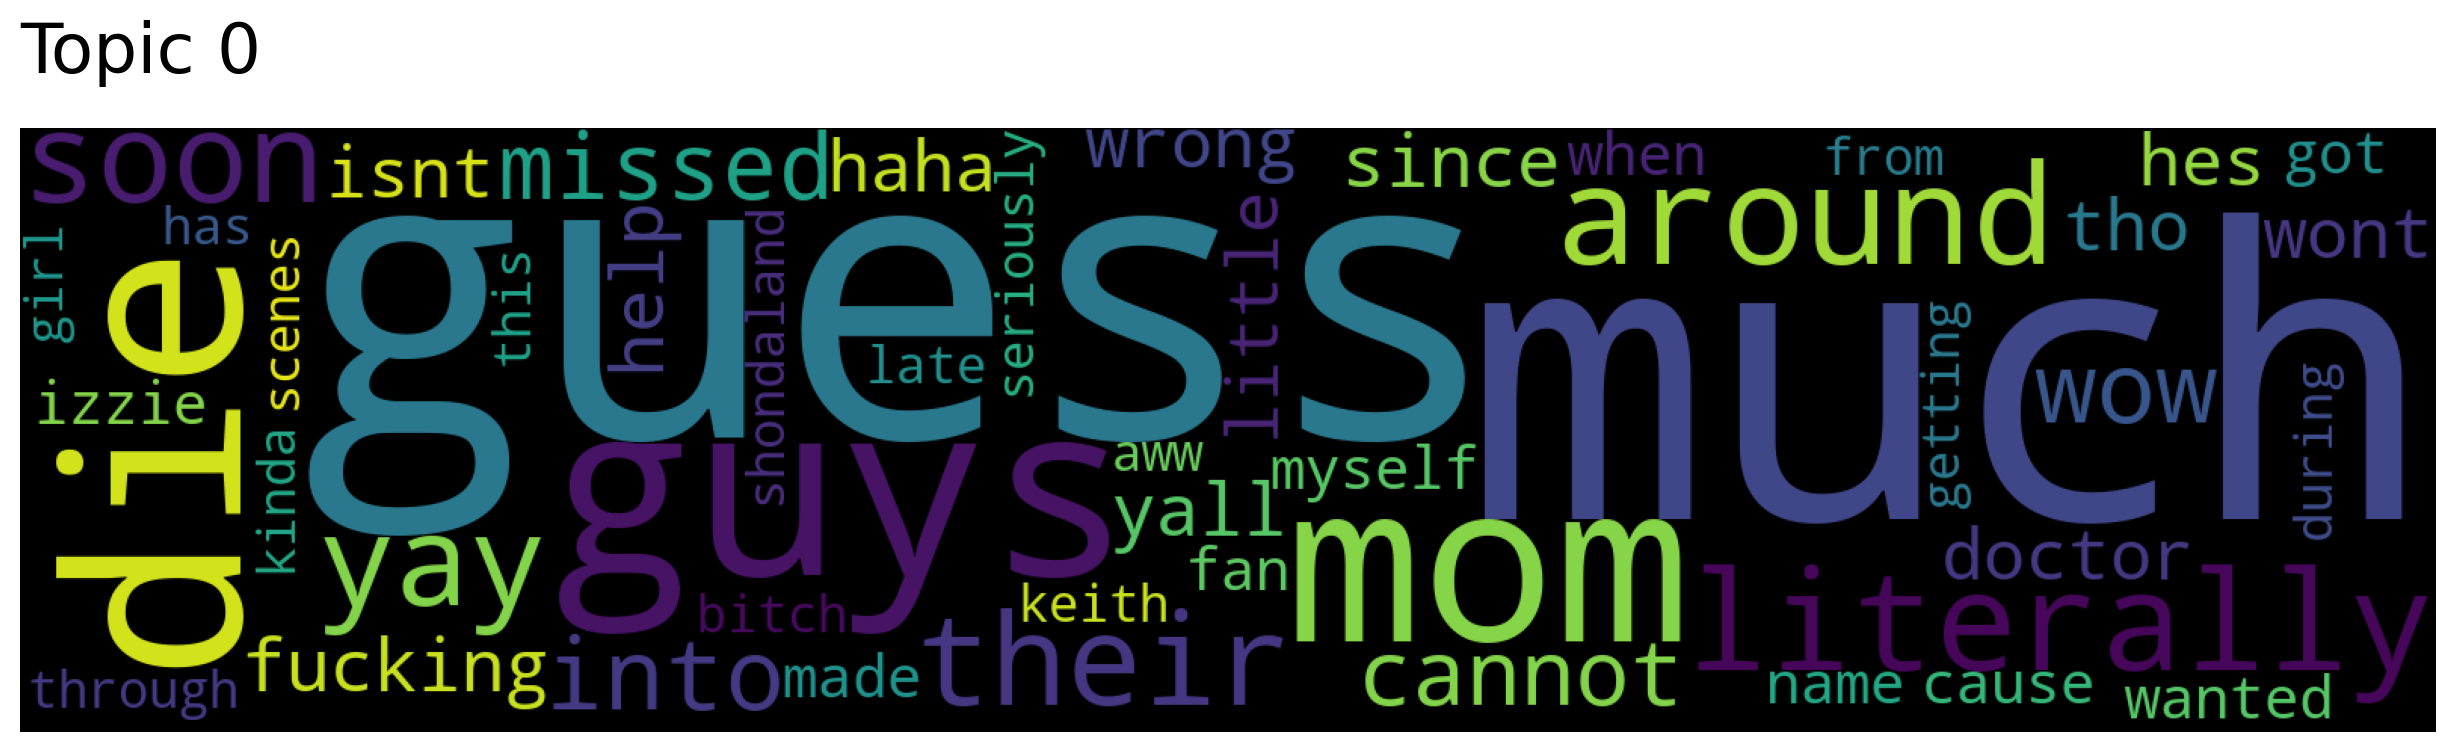

In [47]:
# generate wordcloud to visualize topics
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["mcdreamy"], num_topics=2)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

## LSA

In [8]:
from gensim import models
from gensim import corpora
from gensim.corpora import Dictionary

# create dictionary
corpus = [w for tweet in tweets for w in tweet] # flattening the nested list
dictionary = corpora.Dictionary([corpus])

# convert corpus into a bag of words
bow = [dictionary.doc2bow(tweet) for tweet in tweets]

In [9]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

In [11]:
# find the coherence score with a different number of topics
for i in range(2,9):
    lsi = LsiModel(bow, num_topics=i, id2word=dictionary)
    coherence_model = CoherenceModel(model=lsi, texts=tweets, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.20465250545073752
Coherence score with 3 clusters: 0.17921221513141497
Coherence score with 4 clusters: 0.16988718748433468
Coherence score with 5 clusters: 0.16628791377392413
Coherence score with 6 clusters: 0.2088955254196098
Coherence score with 7 clusters: 0.24371853486509348
Coherence score with 8 clusters: 0.22318747224853297


In [12]:
# perform SVD on the bag of words with the LsiModel to extract 4 topics
lsi = LsiModel(bow,
               id2word=dictionary,
               num_topics=7,
               chunksize=100)

In [13]:
# find the 5 words with the strongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=15):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.668*"season" + 0.465*"finale" + 0.253*"greys" + 0.185*"mcdreamy" + 0.157*"anatomy" + 0.132*"like" + 0.120*"love" + 0.100*"cant" + 0.094*"dont" + 0.091*"next" + 0.086*"derek" + 0.084*"thank" + 0.083*"episode" + 0.079*"happy" + 0.079*"tonight".
Words in 1: 0.574*"mcdreamy" + 0.402*"greys" + -0.389*"season" + 0.301*"anatomy" + -0.291*"finale" + 0.145*"love" + 0.124*"mcsteamy" + 0.122*"like" + 0.107*"derek" + 0.098*"dont" + 0.079*"lexie" + 0.076*"making" + 0.075*"theory" + 0.075*"chyler" + 0.072*"episode".
Words in 2: 0.566*"love" + -0.369*"greys" + -0.301*"anatomy" + 0.267*"dont" + 0.195*"derek" + 0.187*"like" + 0.144*"meredith" + 0.129*"know" + 0.114*"merder" + -0.108*"finale" + 0.102*"cant" + -0.101*"season" + 0.096*"thank" + 0.088*"shonda" + 0.088*"show".
Words in 3: -0.727*"mcdreamy" + 0.465*"greys" + 0.306*"anatomy" + 0.243*"love" + 0.137*"episode" + -0.137*"season" + 0.124*"derek" + -0.083*"mcsteamy" + 0.075*"merder" + 0.070*"watched" + 0.044*"time" + -0.044*"finale" +

## BERTopic

In [21]:
import urllib3, socket
from urllib3.connection import HTTPConnection
    
HTTPConnection.default_socket_options = (HTTPConnection.default_socket_options + [(socket.SOL_SOCKET, socket.SO_SNDBUF, 1000000)])


In [38]:
import re
import string

# additional text cleaning
clean_tweets = []
for t in english_tweets:
    clean_tweet = re.sub(r'(?:\@|https?\://)\S+', '', t).lower()  # regex to remove urls and mentions, lowercasing
    clean_tweet = re.sub('#[A-Za-z0-9_]+', '', clean_tweet)  # remove hashtags
    clean_tweet = clean_tweet.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    clean_tweet = re.sub('([0-9]+)', '', clean_tweet) # remove numbers
    clean_tweets.append(clean_tweet)

In [45]:
# try to improve model performance by adding stopwords with CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(clean_tweets)

OSError: Unable to load weights from pytorch checkpoint file for 'C:\Users\Rachele/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\pytorch_model.bin' at 'C:\Users\Rachele/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\pytorch_model.bin'. If you tried to load a PyTorch model from a TF 2.0 checkpoint, please set from_tf=True.

In [35]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,8952,-1_greysabc_mcdreamy_ellenpompeo_shondarhimes
1,0,1426,0_scandalfinale_scandalabc_scandal_scandalwriters
2,1,816,1_merder_thankyoupatrickdempsey_merders_delena
3,2,577,2_shonda_shondarhimes_boo_girl
4,3,560,3_finale_season_series_boring
...,...,...,...
402,401,11,401_hulu_11th_210_hulusupport
403,402,10,402_debes_revivir_sin_malditashonda
404,403,10,403_depressing_sad_ptsd_miserable
405,404,10,404_thecatch_trailer_thrilling_catandmouse
